In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import math
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
from datetime import datetime

In [3]:
plotly.offline.init_notebook_mode(connected=True)

In [4]:
csv_path = '/Users/pranav/Documents/development/njtransit/csv'

In [166]:
day = '2018_03_02'

In [167]:
day_df = pd.read_csv('{}/{}.csv'.format(csv_path, day))

In [168]:
def clean_delay(sec):
    if sec < 0:
        return 0
    else:
        return sec

# temporarily fix wrong day 
def fix_day(row):
    # wrong day
    if row['delay'] >= (1400*60):
        row['time'] = row['time'] - dt.timedelta(days=1)
        row['delay'] = (row['time'] - row['expected']).total_seconds()
    return row
        
def format_df(df):
    df['expected'] = pd.to_datetime(df['expected'])
    df['time'] = pd.to_datetime(df['time'])

    df['delay']= (df['time']-df['expected']).dt.total_seconds() #calculate delay in seconds
    df['delay']= (df['time']-df['expected']).dt.total_seconds() #calculate delay in seconds
    df = df.apply(fix_day, axis=1)
    df['delay'] = df['delay'].apply(lambda x: clean_delay(x))/60.0 # clean delay and get delay in minutes
    df['status'] = df['status'].fillna("Estimated")
    return df

In [169]:
df = format_df(day_df)

In [170]:
trains = df.groupby(['train_id', 'date'])

In [171]:
trains_last = trains.last()
trains_first = trains.nth(1)

In [172]:
trains_last['day_of_week'] = trains_last['time'].dt.dayofweek
trains_first['day_of_week'] = trains_first['time'].dt.dayofweek

In [173]:
trains_last['hour'] = trains_last['time'].dt.hour
trains_last['sched_hour'] = trains_last['expected'].dt.hour

trains_first['hour'] = trains_first['time'].dt.hour
trains_first['sched_hour'] = trains_first['expected'].dt.hour

In [174]:
trains_last = trains_last[trains_last['type'] == 'NJ Transit'].copy()
trains_first = trains_first[trains_first['type'] == 'NJ Transit'].copy()

In [175]:
def get_severity(row):
    delay = row['delay']
    status = row['status']
    if status == 'Cancelled':
        return "Cancelled"
    if math.isnan(delay):
        return "Unscheduled"
    if 0 <= delay < 3:
        return "On time"
    if 3 <= delay < 6:
        return "3-5 min"
    if 6 <= delay < 10:
        return "6-9 min"
    if 10 <= delay < 20:
        return "10-20 min"
    return "20+ min"

In [176]:
trains_last['severity'] = trains_last.apply(get_severity, axis=1)
trains_first['severity'] = trains_first.apply(get_severity, axis=1)

In [177]:
trains_last.reset_index(level='date', inplace=True)
trains_first.reset_index(level='date', inplace=True)

In [178]:
# turn into dict
colors={'On time': '#39e600', 
        '3-5 min': '#ffff00', 
        '6-9 min': '#ff9933', 
        '10-20 min': '#ff0000', 
        '20+ min': '#990000', 
        'Cancelled': '#827e7d'}
colors_list= ['#39e600', '#ffff00', '#ff9933', '#ff0000', '#990000', '#827e7d']

In [179]:
len(trains_last)

779

In [180]:
len(trains_first)

779

In [181]:
to_nyp = trains_last[trains_last['to'] == "New York Penn Station"].copy()
from_nyp = trains_first[(trains_first['from'] == "New York Penn Station") & (trains_first['severity'] != 'Unscheduled')].copy()

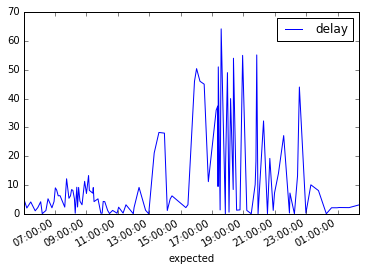

In [182]:
df[(df['from']=='Newark Penn Station') & (df['to']=='Secaucus Upper Lvl')].plot(x='expected', y='delay')

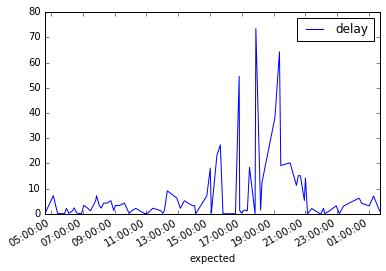

In [183]:
df[(df['from']=='Secaucus Upper Lvl') & (df['to']=='Newark Penn Station')].plot(x='expected', y='delay')

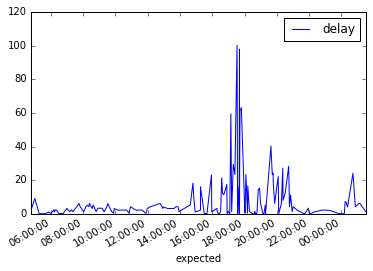

In [184]:
from_nyp.plot(x='expected', y='delay')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1187d0390>]], dtype=object)

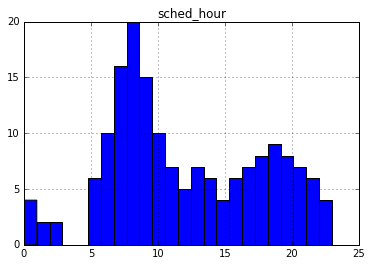

In [185]:
to_nyp.hist('sched_hour', bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1180ec190>]], dtype=object)

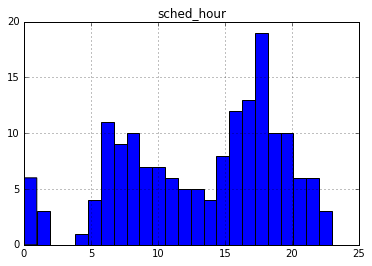

In [186]:
from_nyp.hist('sched_hour', bins=24)

In [187]:
test = to_nyp.copy()
test2 = from_nyp.copy()

In [188]:
test['sequence'] = test.sort_values('time').groupby('sched_hour').cumcount() + 1
test2['sequence'] = test2.sort_values('time').groupby('sched_hour').cumcount() + 1

In [189]:
test['severity_color'] = test['severity'].map(colors)
test2['severity_color'] = test2['severity'].map(colors)

In [190]:
test['id'] = test.index
test2['id'] = test2.index

In [210]:
df[df['train_id'] == '3957']

,train_id,date,stop_sequence,from,from_id,to,to_id,expected,time,status,line,type,delay
1689,3957,2018-03-02,1.0,New York Penn Station,105,New York Penn Station,105,2018-03-02 18:01:00,2018-03-02 18:01:30,Departed,Northeast Corrdr,NJ Transit,0.500000
1690,3957,2018-03-02,2.0,New York Penn Station,105,Newark Penn Station,107,2018-03-02 18:18:00,2018-03-02 18:19:26,Departed,Northeast Corrdr,NJ Transit,1.433333
1691,3957,2018-03-02,NaN,Newark Penn Station,107,Newark Airport,37953,NaT,2018-03-02 18:44:23,Departed,Northeast Corrdr,NJ Transit,NaN
1692,3957,2018-03-02,NaN,Newark Airport,37953,North Elizabeth,109,NaT,2018-03-02 18:44:23,Departed,Northeast Corrdr,NJ Transit,NaN
1693,3957,2018-03-02,NaN,North Elizabeth,109,Elizabeth,41,NaT,2018-03-02 18:47:23,Departed,Northeast Corrdr,NJ Transit,NaN
1694,3957,2018-03-02,NaN,Elizabeth,41,Linden,70,NaT,2018-03-02 18:49:28,Departed,Northeast Corrdr,NJ Transit,NaN
1695,3957,2018-03-02,NaN,Linden,70,Rahway,127,NaT,2018-03-02 18:50:25,Departed,Northeast Corrdr,NJ Transit,NaN
1696,3957,2018-03-02,NaN,Rahway,127,New Brunswick,103,NaT,2018-03-02 18:51:29,Departed,Northeast Corrdr,NJ Transit,NaN
1697,3957,2018-03-02,NaN,New Brunswick,103,Metropark,83,NaT,2018-03-02 18:51:29,Departed,Northeast Corrdr,NJ Transit,NaN
1698,3957,2018-03-02,NaN,Metropark,83,Jersey Avenue,32906,NaT,2018-03-02 18:51:29,Departed,Northeast Corrdr,NJ Transit,NaN


In [192]:
test2[test2['id'] == '3725']

,date,delay,expected,from,from_id,line,status,stop_sequence,time,to,to_id,type,day_of_week,hour,sched_hour,severity,sequence,severity_color,id
train_id,,,,,,,,,,,,,,,,,,,
3725,2018-03-02,29.4,2018-03-02 17:18:00,New York Penn Station,105,Northeast Corrdr,Cancelled,2.0,2018-03-02 17:47:24,Secaucus Upper Lvl,38187,NJ Transit,4,17,17.0,Cancelled,7,#827e7d,3725


In [193]:
trace1 = go.Scatter(
    x = test['sched_hour'],
    y = test['sequence'],
    mode='markers',
    marker=dict(
        size='16',
        color = test['severity_color'], #set color equal to a variable
    ),
    text = test['line'] + test['id']
)
data = [trace1]
plotly.offline.iplot(data)


In [204]:
test2[test2.index == '3861']

,date,delay,expected,from,from_id,line,status,stop_sequence,time,to,to_id,type,day_of_week,hour,sched_hour,severity,sequence,severity_color,id
train_id,,,,,,,,,,,,,,,,,,,
3861,2018-03-02,12.283333,2018-03-02 16:38:00,New York Penn Station,105,Northeast Corrdr,Departed,2.0,2018-03-02 16:50:17,Secaucus Upper Lvl,38187,NJ Transit,4,16,16.0,10-20 min,7,#ff0000,3861


In [205]:
trace2 = go.Scatter(
    x = test2['sched_hour'],
    y = test2['sequence'],
    mode='markers',
    marker=dict(
        size='16',
        color = test2['severity_color'], #set color equal to a variable
    ),
    text= test2['line'] + test2['id']
)
data = [trace2]
plotly.offline.iplot(data)

In [108]:
test2[test2['sched_hour'] == 18]

,date,delay,expected,from,from_id,line,status,stop_sequence,time,to,to_id,type,day_of_week,hour,sched_hour,severity,sequence,severity_color
train_id,,,,,,,,,,,,,,,,,,
3173,2018-03-02,0.533333,2018-03-02 18:01:00,New York Penn Station,105,Northeast Corrdr,Departed,2.0,2018-03-02 18:01:32,Secaucus Upper Lvl,38187,NJ Transit,4,18,18.0,On time,1,#39e600
3271,2018-03-02,38.333333,2018-03-02 18:05:00,New York Penn Station,105,No Jersey Coast,Departed,2.0,2018-03-02 18:43:20,Secaucus Upper Lvl,38187,NJ Transit,4,18,18.0,20+ min,15,#990000
3275,2018-03-02,1.383333,2018-03-02 18:38:00,New York Penn Station,105,No Jersey Coast,Departed,2.0,2018-03-02 18:39:23,Secaucus Upper Lvl,38187,NJ Transit,4,18,18.0,On time,11,#39e600
3373,2018-03-02,30.533333,2018-03-02 18:12:00,New York Penn Station,105,No Jersey Coast,Departed,2.0,2018-03-02 18:42:32,Secaucus Upper Lvl,38187,NJ Transit,4,18,18.0,20+ min,13,#990000
3515,2018-03-02,0.150000,2018-03-02 18:43:00,New York Penn Station,105,No Jersey Coast,Departed,4.0,2018-03-02 18:43:09,Newark Airport,37953,NJ Transit,4,18,18.0,On time,14,#39e600
3727,2018-03-02,0.366667,2018-03-02 18:11:00,New York Penn Station,105,Northeast Corrdr,Departed,4.0,2018-03-02 18:11:22,Rahway,127,NJ Transit,4,18,18.0,On time,3,#39e600
3731,2018-03-02,0.500000,2018-03-02 18:46:00,New York Penn Station,105,Northeast Corrdr,Departed,2.0,2018-03-02 18:46:30,Secaucus Upper Lvl,38187,NJ Transit,4,18,18.0,On time,16,#39e600
3873,2018-03-02,1.216667,2018-03-02 18:30:00,New York Penn Station,105,Northeast Corrdr,Departed,2.0,2018-03-02 18:31:13,Newark Penn Station,107,NJ Transit,4,18,18.0,On time,7,#39e600
3875,2018-03-02,15.283333,2018-03-02 18:56:00,New York Penn Station,105,Northeast Corrdr,Departed,2.0,2018-03-02 19:11:17,Secaucus Upper Lvl,38187,NJ Transit,4,19,18.0,10-20 min,19,#ff0000
